<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#side-note-on-PPA-api-manipulation" data-toc-modified-id="side-note-on-PPA-api-manipulation-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>side note on PPA api manipulation</a></span></li></ul></li><li><span><a href="#'bt'-backtesting-library-on-1-year-of-PPAs" data-toc-modified-id="'bt'-backtesting-library-on-1-year-of-PPAs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>'bt' backtesting library on 1 year of PPAs</a></span><ul class="toc-item"><li><span><a href="#data-format" data-toc-modified-id="data-format-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>data format</a></span></li><li><span><a href="#data-passing" data-toc-modified-id="data-passing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>data passing</a></span></li></ul></li><li><span><a href="#'backtesting'-library" data-toc-modified-id="'backtesting'-library-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>'backtesting' library</a></span></li><li><span><a href="#from-scratch" data-toc-modified-id="from-scratch-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>from scratch</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#function-notes" data-toc-modified-id="function-notes-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>function notes</a></span></li></ul></li></ul></li><li><span><a href="#graphing-results" data-toc-modified-id="graphing-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>graphing results</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#figured-out-the-timestamp-runtime-issue" data-toc-modified-id="figured-out-the-timestamp-runtime-issue-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>figured out the timestamp runtime issue</a></span></li></ul></li><li><span><a href="#plot-cash-&amp;-coin-together" data-toc-modified-id="plot-cash-&amp;-coin-together-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>plot cash &amp; coin together</a></span></li><li><span><a href="#plotting-gross-wealth-against-btc_price" data-toc-modified-id="plotting-gross-wealth-against-btc_price-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>plotting gross wealth against btc_price</a></span></li></ul></li><li><span><a href="#oh-that's-HILARIOUS" data-toc-modified-id="oh-that's-HILARIOUS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>oh that's HILARIOUS</a></span><ul class="toc-item"><li><span><a href="#I-thought-this-lost-money" data-toc-modified-id="I-thought-this-lost-money-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>I thought this lost money</a></span></li><li><span><a href="#but-i-forgot-that-bitcoin-price-changes-over-time" data-toc-modified-id="but-i-forgot-that-bitcoin-price-changes-over-time-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>but i forgot that bitcoin price changes over time</a></span></li><li><span><a href="#it-actually-grew-the-initial-investment-by-450%-in-gross-wealth" data-toc-modified-id="it-actually-grew-the-initial-investment-by-450%-in-gross-wealth-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>it actually grew the initial investment by 450% in gross wealth</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import bt

## side note on PPA api manipulation
ideally i want to make an easy way to have a 'rolling feed' of PPAs imposed on a tableau or trader software interface. bitcoin just dipped below 11k for the first time in a month - makes me think "are there any PPAs going on recently?" 

# 'bt' backtesting library on 1 year of PPAs
tricky bit will be defining new algos based on PPAs

In [ ]:
s = bt.Strategy('s1', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

- bt runs a strategy on data. i have the data, time to build a strategy.
- strategy is just a name and a list of algos.
    - algos:
        - a function that returns boolean
    - list of algos: "algoStack"
        - chained so that they execute consecutively, one False will stop execution part-way

In [2]:
class MyAlgo(bt.Algo):

    def __init__(self, arg1, arg2):
        self.arg1 = arg1
        self.arg2 = arg2

    def __call__(self, target):
        # my logic goes here

        # accessing/storing variables through target.temp['key']

        # remember to return a bool - True in most cases
        return True

## data format
doesn't seem to be that complex. the algo examples saying target['spy'] is probably referring to row['col_name'].
- every row, it runs the algos and... decides what to do, based on true/false. how does it determine the buy/sell? 

## data passing
In order to pass data between different Algos, the Strategy has two properties: temp and perm. They are both dictionaries and are used for storing data generated by Algos. Temporary data is refreshed on each data change whereas permanent data is not altered.

Algos usually set and/or require values in the temp or perm objects. For example, the bt.algos.WeighEqually Algo sets the ‘weights’ key in temp, and it requires the ‘selected’ key in temp.

For example, let’s take a simple select -> weight -> allocate logic chain. We would break this strategy up into 3 Algos:

selection Which securities do I want to allocate capital to out of the entire universe of investable assets?
weighting How much weight should each of the selected securities have in the target portfolio?
allocate Close out positions that are no longer needed and allocate capital to those that were selected and given target weights.
In this case, the selection Algo could set the ‘selected’ key in the strategy’s temp dict, and the weighting Algo could read those values and in turn set the ‘weights’ key in the temp dict. The allocation Algo would then read the ‘weights’ and act accordingly.

In [ ]:
class WeighEqually(Algo):
    """
    Sets temp['weights'] by calculating equal weights for all items in
    selected.

    Equal weight Algo. Sets the 'weights' to 1/n for each item in 'selected'.
    
    Sets:
        * weights
    Requires:
        * selected
    """
    def __init__(self):
        super(WeighEqually, self).__init__()

    def __call__(self, target):
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}

        return True


In [3]:
data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')

In [5]:
data.head(10)

,aapl,msft,c,gs,ge
Date,,,,,
2010-01-04,6.604801,24.168472,30.533976,147.920776,10.733057
2010-01-05,6.616219,24.176279,31.701447,150.535919,10.788632
2010-01-06,6.510980,24.027906,32.689320,148.929138,10.733057
2010-01-07,6.498945,23.778025,32.779129,151.843475,11.288810
2010-01-08,6.542150,23.942017,32.240284,148.971909,11.531955
2010-01-11,6.484439,23.637472,32.599525,146.621704,11.643106
2010-01-12,6.410679,23.481291,31.611656,143.425323,11.650054
2010-01-13,6.501104,23.699940,31.432041,144.493607,11.691734
2010-01-14,6.463451,24.176279,31.521839,144.032120,11.601420


# 'backtesting' library

In [6]:
import backtesting

/Users/mark/.local/lib/python3.7/site-packages/backtesting/_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [7]:
# Example OHLC daily data for Google Inc.
from backtesting.test import GOOG

GOOG.tail()

,Open,High,Low,Close,Volume
2013-02-25,802.3,808.41,790.49,790.77,2303900
2013-02-26,795.0,795.95,784.40,790.13,2202500
2013-02-27,794.8,804.75,791.11,799.78,2026100
2013-02-28,801.1,806.99,801.03,801.20,2265800
2013-03-01,797.8,807.14,796.15,806.19,2175400


In [8]:
# simple moving-average + crossover strategy
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().

Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, vectorized manner whatever indicators and signals the strategy depends on.

Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), simulating the incremental availability of each new full candlestick bar.

Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the next candle's open (or the current candle's close if trade_on_close=True). If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin with more fine-grained (e.g. hourly) data.

In [ ]:
from backtesting import Strategy
from backtesting.lib import crossover

class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 10
    n2 = 20
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self): # these are the methods i want for "if ppa".
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In [10]:
df = pd.read_csv('historical_crypto_btc.csv')

In [12]:
for col in list(df.columns):
    if 'alert' in col:
        print(col)

5min_long_alert
5min_short_alert
30min_long_alert
30min_short_alert
60min_long_alert
60min_short_alert


In [13]:
df.columns

Index(['asset_class', 'asset_name', 'timestamp', 'low', 'high', 'open',
       'close', '5min_long_alert', '5min_long_10pct_conf',
       '5min_long_25pct_conf', '5min_long_50pct_conf', '5min_long_75pct_conf',
       '5min_short_alert', '5min_short_10pct_conf', '5min_short_25pct_conf',
       '5min_short_50pct_conf', '5min_short_75pct_conf', '30min_long_alert',
       '30min_long_10pct_conf', '30min_long_25pct_conf',
       '30min_long_50pct_conf', '30min_long_75pct_conf', '30min_short_alert',
       '30min_short_10pct_conf', '30min_short_25pct_conf',
       '30min_short_50pct_conf', '30min_short_75pct_conf', '60min_long_alert',
       '60min_long_10pct_conf', '60min_long_25pct_conf',
       '60min_long_50pct_conf', '60min_long_75pct_conf', '60min_short_alert',
       '60min_short_10pct_conf', '60min_short_25pct_conf',
       '60min_short_50pct_conf', '60min_short_75pct_conf'],
      dtype='object')

In [17]:
st = '60min_short_50pct_conf'
ind = st.index("min") # 2
s = st[:ind]
s

'60'

- setting up logic is tricky here
- if ppa does not exist:
    - do nothing
- else: # ppa exists
    - if direction=='long':
        - buy, sell when

In [ ]:
# simple moving-average + crossover strategy
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

def ppa(row, alert_names):
    # checks row to see if ppa is present or not. 
    # returns True/False, direction, length and confidence_value_dict of PPA
    for alert in alert_names:
        if row[alert] == 1: # if ppa begins
            # get the four confidence interval values for this alert
            ind = alert.index('min') # 1 or 2, for 5,30,60
            length = int(alert[:ind]) # 5, 30 or 60 minutes
            # direction
            if 'long' in alert:
                direction = 'long'
            else:
                direction = 'short'
            # store confidence intervals
        else:
            return None
    return ppa

class ppa_thresh(Strategy): # self.data accesses dataframe
    bars = 15
    bar_length = 1
    
    def init(self):
        # no precomputation, since our df has signals baked-in
    def next(self):
        # if ppa
        if ppa()

# from scratch
maybe if i try writing it myself, i'll learn the critical aspects of coding it in these backtesting libraries.

it'll be far from a finished product, without all the bells and whistles (graphs, metrics) built into the libraries, but it's a good start for logic.

In [2]:
import os
from os import listdir
from os.path import isfile, join
onlyfiles = [file for file in listdir(os.getcwd()) if isfile(join(os.getcwd(), file)) and 'csv' in file]

In [3]:
onlyfiles

['coinbase_btc_hourly.csv', 'ppas.csv', 'historical_crypto_btc.csv']

In [4]:
df = pd.read_csv('historical_crypto_btc.csv')
df.head()

,asset_class,asset_name,timestamp,low,high,open,close,5min_long_alert,5min_long_10pct_conf,5min_long_25pct_conf,...,60min_long_alert,60min_long_10pct_conf,60min_long_25pct_conf,60min_long_50pct_conf,60min_long_75pct_conf,60min_short_alert,60min_short_10pct_conf,60min_short_25pct_conf,60min_short_50pct_conf,60min_short_75pct_conf
0,crypto,btc,2017-01-01 0:00,973.35,973.40,973.37,973.39,0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,crypto,btc,2017-01-01 0:05,970.95,973.39,973.35,972.62,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,crypto,btc,2017-01-01 0:10,970.42,971.94,971.94,970.42,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,crypto,btc,2017-01-01 0:15,969.90,971.18,970.42,969.90,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,crypto,btc,2017-01-01 0:20,969.94,970.77,970.09,970.77,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- if bitcoin_price is 1000, and you buy \$100 USD worth of BTC
    - you get 1/10th of a bitcoin. how do we math this?
    - purchased_btc = 100 / 1000 = 1/10 = spent_USD / BTC_price
- if btc_price = 1000, and you have one bitcoin & sell half of it, you get $500 usd
    - purchased_usd = spent_BTC * BTC_price
    - 500 = 0.5(BTC) * 1000

In [5]:
class portfolio:
    # store a current_balance of BTC and USD + current bitcoin_price (relative USD)
    stops = [] # empty list of auto-stops
    def __init__(self, usd, btc, price):
        self.usd = usd # $dollars in portfolio
        self.btc = btc # number of bitcoins in portfolio
        self.price = price # current price of bitcoin/usd
    
    # buy/sell equations. the mirrored n/ n* is sort of elegant, didn't plan that one
    def buy(self, n): # convert $n USD to BTC
        self.usd -= n # spend $n
        self.btc += (n/self.price) # to purchase BTC
        
    def sell(self, n): # convert n BTC to USD (both are stored in their own units)
        self.usd += n*self.price # sell n bitcoins at price = usd_gained
        self.btc -= (n) # by spending BTC
        
class auto_stop:
    # stores auto buy or sell point that a class can possess multiple of (or none)
    def __init__(self, initial, direction, thresh, period):
        self.initial = initial # BTC price at which stop was set against
        self.direction = direction # 
        self.thresh = thresh # threshold at which to buy/sell
        self.period = period # number of rows remaining in active period of PPA



p = portfolio(2000, 1, 1000) # $2000 USD starting, no BTC. 1btc / $1000 USD
print(p.usd,p.btc)

p.buy(0.1*p.usd)
print(p.usd,p.btc)

p.sell(0.1*p.btc)
print(p.usd,p.btc)


2000 1
1800.0 1.2
1920.0 1.08


In [11]:
df.columns

Index(['asset_class', 'asset_name', 'timestamp', 'low', 'high', 'open',
       'close', '5min_long_alert', '5min_long_10pct_conf',
       '5min_long_25pct_conf', '5min_long_50pct_conf', '5min_long_75pct_conf',
       '5min_short_alert', '5min_short_10pct_conf', '5min_short_25pct_conf',
       '5min_short_50pct_conf', '5min_short_75pct_conf', '30min_long_alert',
       '30min_long_10pct_conf', '30min_long_25pct_conf',
       '30min_long_50pct_conf', '30min_long_75pct_conf', '30min_short_alert',
       '30min_short_10pct_conf', '30min_short_25pct_conf',
       '30min_short_50pct_conf', '30min_short_75pct_conf', '60min_long_alert',
       '60min_long_10pct_conf', '60min_long_25pct_conf',
       '60min_long_50pct_conf', '60min_long_75pct_conf', '60min_short_alert',
       '60min_short_10pct_conf', '60min_short_25pct_conf',
       '60min_short_50pct_conf', '60min_short_75pct_conf'],
      dtype='object')

In [7]:
alerts = [col for col in list(df.columns) if 'alert' in col]
alerts

['5min_long_alert',
 '5min_short_alert',
 '30min_long_alert',
 '30min_short_alert',
 '60min_long_alert',
 '60min_short_alert']

In [41]:
st = '5min_short_25pct_conf'
indx = st.index('pct') # 13
st[indx-2:indx]

'25'

In [45]:
p.stops.append(auto_stop('long', 20, 15)) # 5-minute long at $20
p.stops

In [25]:
df.columns

Index(['asset_class', 'asset_name', 'timestamp', 'low', 'high', 'open',
       'close', '5min_long_alert', '5min_long_10pct_conf',
       '5min_long_25pct_conf', '5min_long_50pct_conf', '5min_long_75pct_conf',
       '5min_short_alert', '5min_short_10pct_conf', '5min_short_25pct_conf',
       '5min_short_50pct_conf', '5min_short_75pct_conf', '30min_long_alert',
       '30min_long_10pct_conf', '30min_long_25pct_conf',
       '30min_long_50pct_conf', '30min_long_75pct_conf', '30min_short_alert',
       '30min_short_10pct_conf', '30min_short_25pct_conf',
       '30min_short_50pct_conf', '30min_short_75pct_conf', '60min_long_alert',
       '60min_long_10pct_conf', '60min_long_25pct_conf',
       '60min_long_50pct_conf', '60min_long_75pct_conf', '60min_short_alert',
       '60min_short_10pct_conf', '60min_short_25pct_conf',
       '60min_short_50pct_conf', '60min_short_75pct_conf'],
      dtype='object')

In [98]:
from tqdm.notebook import tqdm_notebook
alerts = [col for col in list(df.columns) if 'alert' in col]

def backtest(p, df):
    cash = [] # storage of portfolio's USD & BTC over time
    coin = [] # index-aligned with the dataframe for easy graphing
    for i, row in tqdm_notebook(df.iterrows()): # loop through dataframe
        # iterative maintenance
        p.price = row['close'] # update BTC price with this row's data
        # check for any PPAs activating this row
        for alert in alerts:
            if row[alert] == 1:  # if PPA activates now
                ppa = True
                # set length, period, direction of alert
                length = alert[:alert.index('min')] # 5, 30 or 60 for 15, 90 or 
                if length == '5': period = 15
                else: period = int(length) * 15 # if i did the math right this should work
                if 'long' in alert: 
                    direction = 1
                    direct = 'long'
                else: 
                    direction = -1
                    direct = 'short'
                # get conf
                conf_dict = {}
#                 '5min_short_10pct_conf' # target
#                 for i
#                 tar = str(length)+'min_'+direct
                for col in list(df.columns):
                    if (str(length)+'min_'+direct in col and 'pct' in col):
#                     if str(length) in col and 'pct' in col and direct in col: # one of four %s for that length/direction
#                         print('at index ' + str(i))
#                         print(col)
#                         print(alert, row[alert])
#                         print(row['timestamp'])
                        ind = col.index('pct')
                        conf = col[ind-2:ind] # 10, 25, 50 or 75
                        try:
                            val = int(row[col])
                            conf_dict[conf] = val # assign (conf: val) pair to dict
                        except Exception as e:
#                             print(e)
                            ppa = False
#                             print('')
                        
                # confidence values recorded
                # if PPA: buy/sell according to direction
                if ppa:
#                     print('buying/selling based on PPA direction')
                    investment = 0.1 # ratio. invest one-tenth of your wealth, predicting the spike
                    initial = row['close'] # initial BTC_price at which stop is set
#                     print(conf_dict)
                    if direct=='long':
                        p.buy(p.usd * investment)
                        p.stops.append(auto_stop(initial, direction, conf_dict["75"], period))
                    elif direct=='short':
                        p.sell(p.btc * investment)
                        p.stops.append(auto_stop(initial, direction, conf_dict["75"], period))
            # end PPA activity
        # regardless of PPA active or not:
        # if stops active: de-increment each
            # check if current BTC_price has passed any thresholds of stops; if so, sell/buy accordingly
        if p.stops: # if active stops, de-increment its period by one (row), simulate passing of time
            for stop in p.stops:
                stop.period -= 1
                if stop.period <= 0:
                    p.stops.remove(stop) # delete expired stops
                # check if price has eclipsed the threshold of any stop
                if (stop.direction=='long' and row['close'] >= stop.initial+stop.thresh):
                    # your auto-stop long gambit paid off, you lucker dog. time to sell
                    p.sell(p.btc * investment)
                elif (stop.direction=='short' and row['close'] <= stop.initial-stop.thresh):
                    # your short strategy actually came through, time to buy
                    p.buy(p.usd * investment)
        cash.append(p.usd)
        coin.append(p.btc)
    # end function
    return cash, coin

# create new portfolio initial monies
p = portfolio(10000, 5, df.iloc[0]['close'])

cash, coin = backtest(p, df)
                

### function notes
- some PPAs early on will set alerts but have NaN for their confidence intervals
    - while the algo is still learning the data, it won't put out good predictions, and would prefer to offer no insight than poor insight

# graphing results

this took a long time to graph. so long, in fact, i stopped and investigated the values.
max(cash) was 'inf', so. I think i may have done something awfully wrong.

indeed, there was a hilarious error in my sell() method that would send any portfolio spiraling into (negative) infinity after a few transactions. if the numbers are infinity, the math is probably wrong.

In [99]:
df['cash'] = cash
df['coin'] = coin
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
df['coin'].describe()

count    378457.000000
mean          3.091237
std           1.333944
min           0.026037
25%           2.080628
50%           2.983437
75%           3.990907
max           7.707591
Name: coin, dtype: float64

In [101]:
ls = list(df['coin'])
min(ls)

0.026037239525525738

In [102]:
ls = list(df['cash'])
min(ls)

198.40337461028003

In [103]:
df['cash'].describe()

count    378457.000000
mean      18527.409341
std        8350.857708
min         198.403375
25%       11743.257808
50%       17421.695709
75%       23871.152032
max       58677.984281
Name: cash, dtype: float64

In [104]:
print(df.iloc[-1].cash, df.iloc[-1].coin) # started with $3,000 and 1 BTC
# seems bad, but we maxed out at $14,000 cash and 1.89 BTC.
# the buy/sell methods work fine. maybe something off with my stop methods?

10829.478421233007 3.0800863544889516


In [106]:
mel = pd.melt(df, id_vars=['timestamp'], value_vars=['cash','coin'])
mel.head()

,timestamp,variable,value
0,2017-01-01 00:00:00,cash,10000.0
1,2017-01-01 00:05:00,cash,10000.0
2,2017-01-01 00:10:00,cash,10000.0
3,2017-01-01 00:15:00,cash,10000.0
4,2017-01-01 00:20:00,cash,10000.0


/Users/mark/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


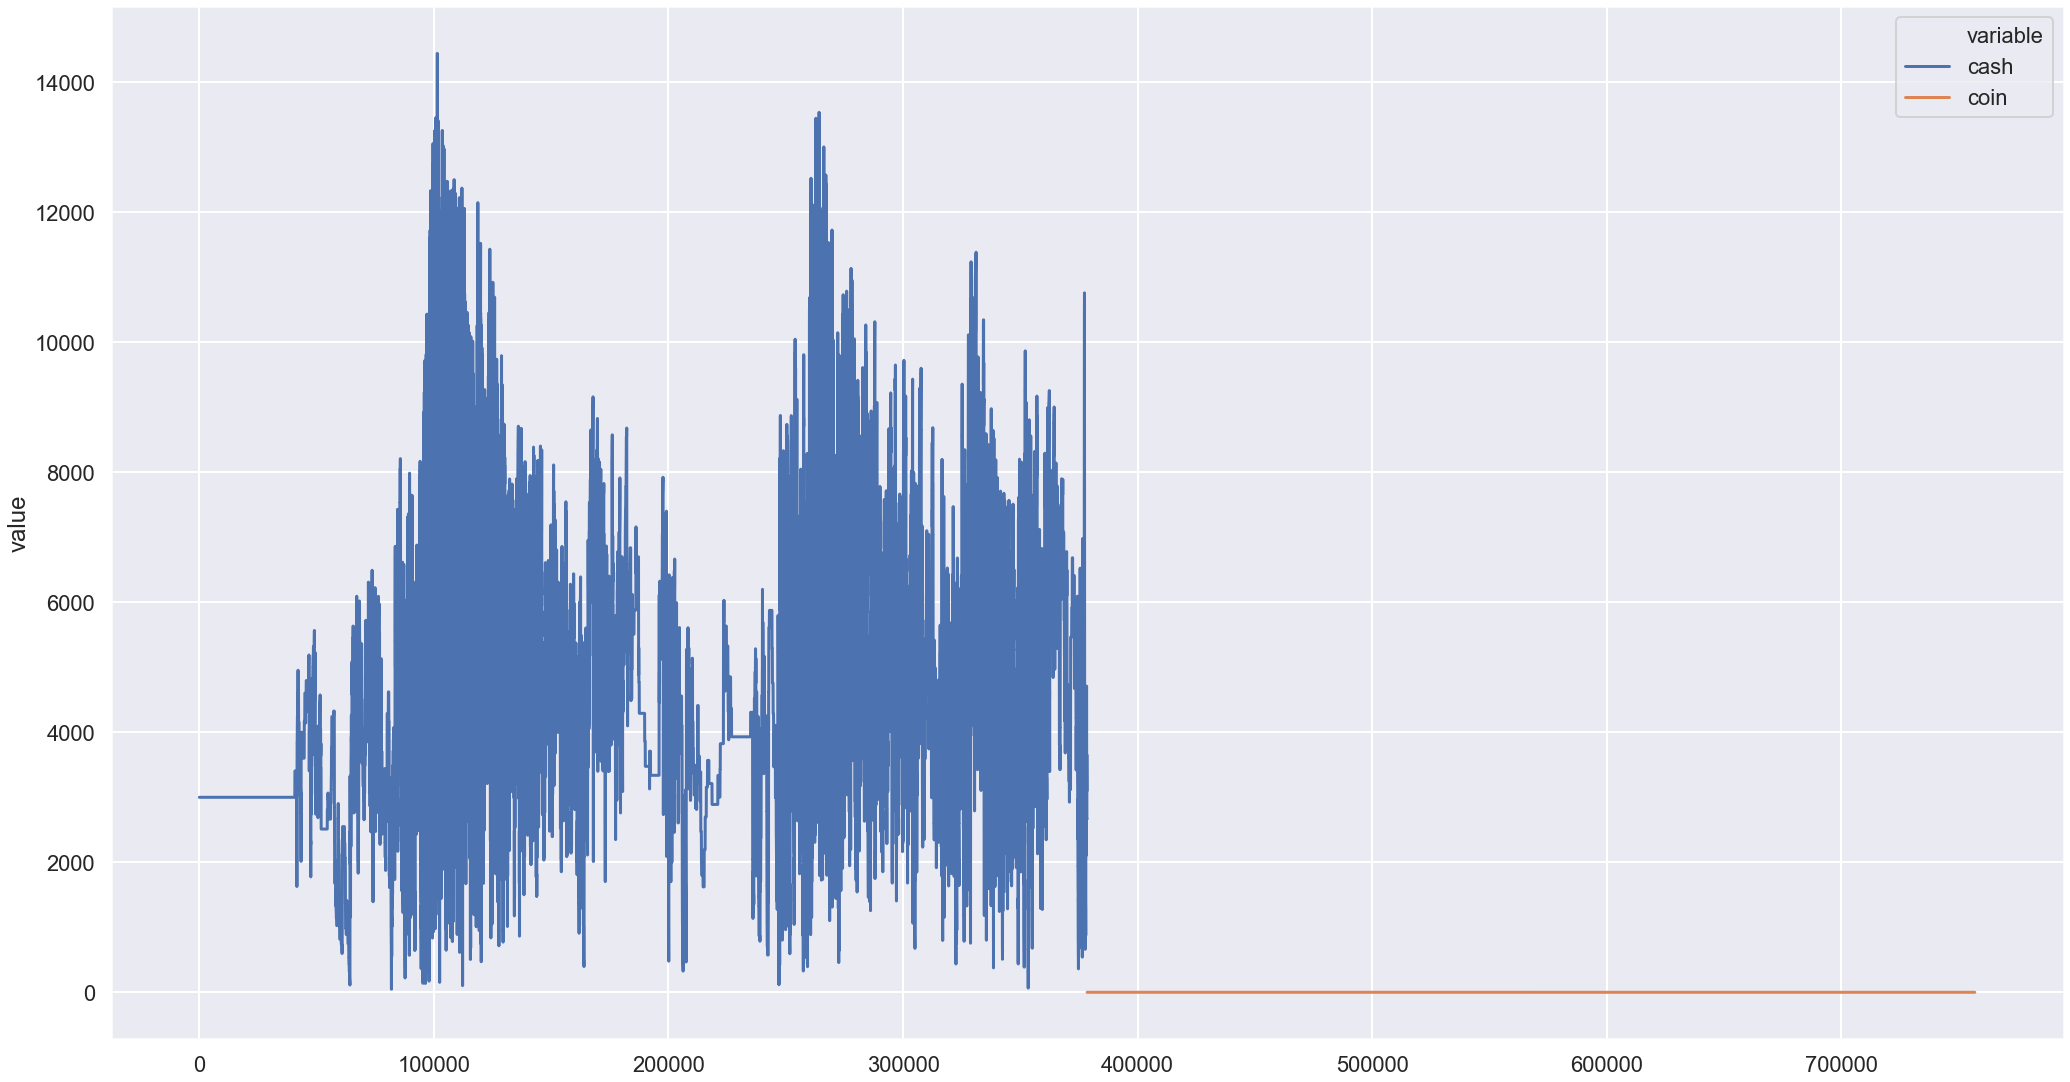

In [19]:
# sub = sub.iloc[:100000]
# this graph ran decently fast when i just used a list of ints instead of timestamps
# with timestamps, it's not really going anywhere after 10 minutes. maybe some formatting issue 

sns.set(style="darkgrid", rc={'figure.figsize':(35,19)})
sns.set_context('poster')
# mel = pd.melt(df, id_vars=['timestamp'], value_vars=['cash','coin'])
# mel.head()
# this graph is taking SO_LONG to run holy moly
# i feel like timestamp is to blame, i'll just replace it with filler ints
sns.lineplot(data=mel, x=nums, y='value', hue='variable')
plt.show()

### figured out the timestamp runtime issue
timestamps were strings, not datetime. should have seen that one coming, really.
## plot cash & coin together

In [141]:
sub = df
sub['adj_coin'] = sub.apply(lambda row: row['coin']*row['close'], axis=1)

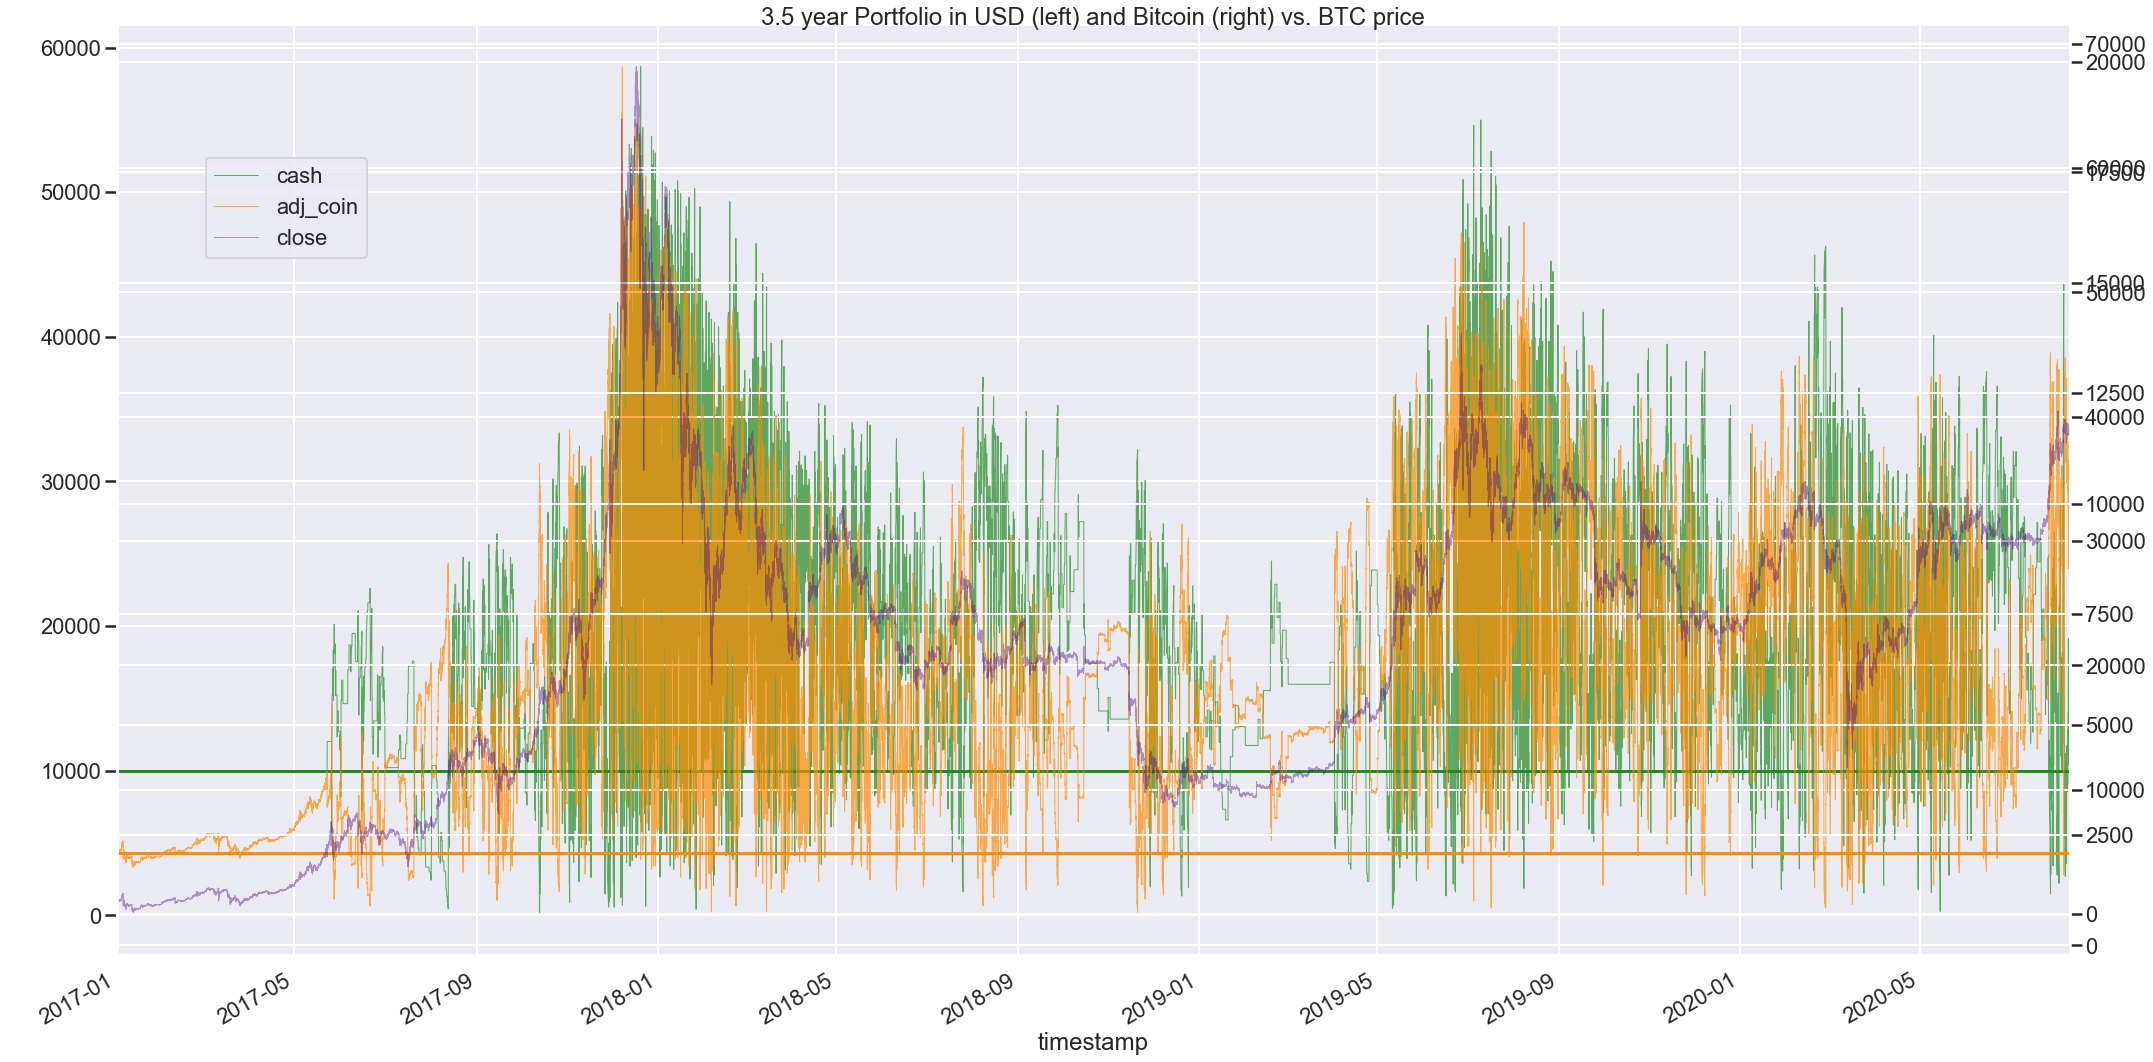

In [160]:
def draw_portfolio(df): # dataframe. subset the timestamps to zoom in on an area

    sns.set(style="darkgrid", rc={'figure.figsize':(35,19)})
    sns.set_context('poster')
    
    w = 1 # line width
    # tinkering with alpha levels to make it more readable
    ax = df.plot(x="timestamp", y='cash', color='forestgreen', alpha=0.7, legend=False,linewidth=w)

    ax2 = ax.twinx() # twin axes for multilines
    df.plot(x="timestamp", y='adj_coin', ax=ax2, color='darkorange', alpha=0.7, legend=False,linewidth=w)

    ax3 = ax.twinx()
    df.plot(x='timestamp', y='close', ax=ax3, color='indigo', alpha=0.4, legend=False,linewidth=w, 
#             tick_params={
#     axis:'y',          # changes apply to the x-axis
#     which:'both',      # both major and minor ticks are affected
#     bottom:False,      # ticks along the bottom edge are off
#     top:False,         # ticks along the top edge are off
#     labelbottom:False}
           )

    ax.figure.legend(loc='lower right', bbox_to_anchor=(0.15, 0.58, 0,0))
    plt.title('3.5 year Portfolio in USD (left) and Bitcoin (right) vs. BTC price',
              fontdict={'verticalalignment': 'center',})
    # horizontal lines denote starting investment
    ax.axhline(y=df.iloc[0]['cash'], color='forestgreen')
    ax2.axhline(y=df.iloc[0]['adj_coin'], color='darkorange')

    plt.show()
    return

last = sub[-1000:]
draw_portfolio(sub)

## plotting gross wealth against btc_price

In [122]:
def calc_gross(row): # gross wealth of 'coin' and 'cash' in usd
    # just multiply 'coin' by 'closing_price' and add to cash
    gross = row['cash'] + (row['coin']*row['close'])
    return gross
df['gross'] = df.apply(lambda row: calc_gross(row), axis=1)


In [166]:
print('gross wealth stats','\n',df['gross'].describe(), '\n'*2)


print('|||| INITIAL INVESTMENT: ||||', '\n', 'CASH: '+str(df.iloc[0]['cash']), '  ',
     'BITCOINS: '+str(df.iloc[0]['coin']), '\n')

print('BITCOIN_PRICE initial -> end:')
print(df.iloc[0]['close'])
print(df.iloc[-1]['close'], '\n')

print('GROSS WEALTH initial -> end:')
print(df.iloc[0]['gross'])
print(df.iloc[-1]['gross'], '\n')

print('CASH_possessed initial -> end:')
print(df.iloc[0]['cash'])
print(df.iloc[-1]['cash'], '\n')

print('BITCOIN_possessed initial -> end:')
print(df.iloc[0]['coin'])
print(df.iloc[-1]['coin'], '\n')



gross wealth stats 
 count    378457.000000
mean      36794.205722
std       11108.126702
min       13733.050000
25%       30274.600132
50%       37647.271166
75%       44193.008648
max       72345.177744
Name: gross, dtype: float64 


|||| INITIAL INVESTMENT: |||| 
 CASH: 10000.0    BITCOINS: 5.0 

BITCOIN_PRICE initial -> end:
973.39
11650.0 

GROSS WEALTH initial -> end:
14866.95
46712.48445102929 

CASH_possessed initial -> end:
10000.0
10829.478421233007 

BITCOIN_possessed initial -> end:
5.0
3.0800863544889516 



# oh that's HILARIOUS
## I thought this lost money
## but i forgot that bitcoin price changes over time
## it actually grew the initial investment by 450% in gross wealth

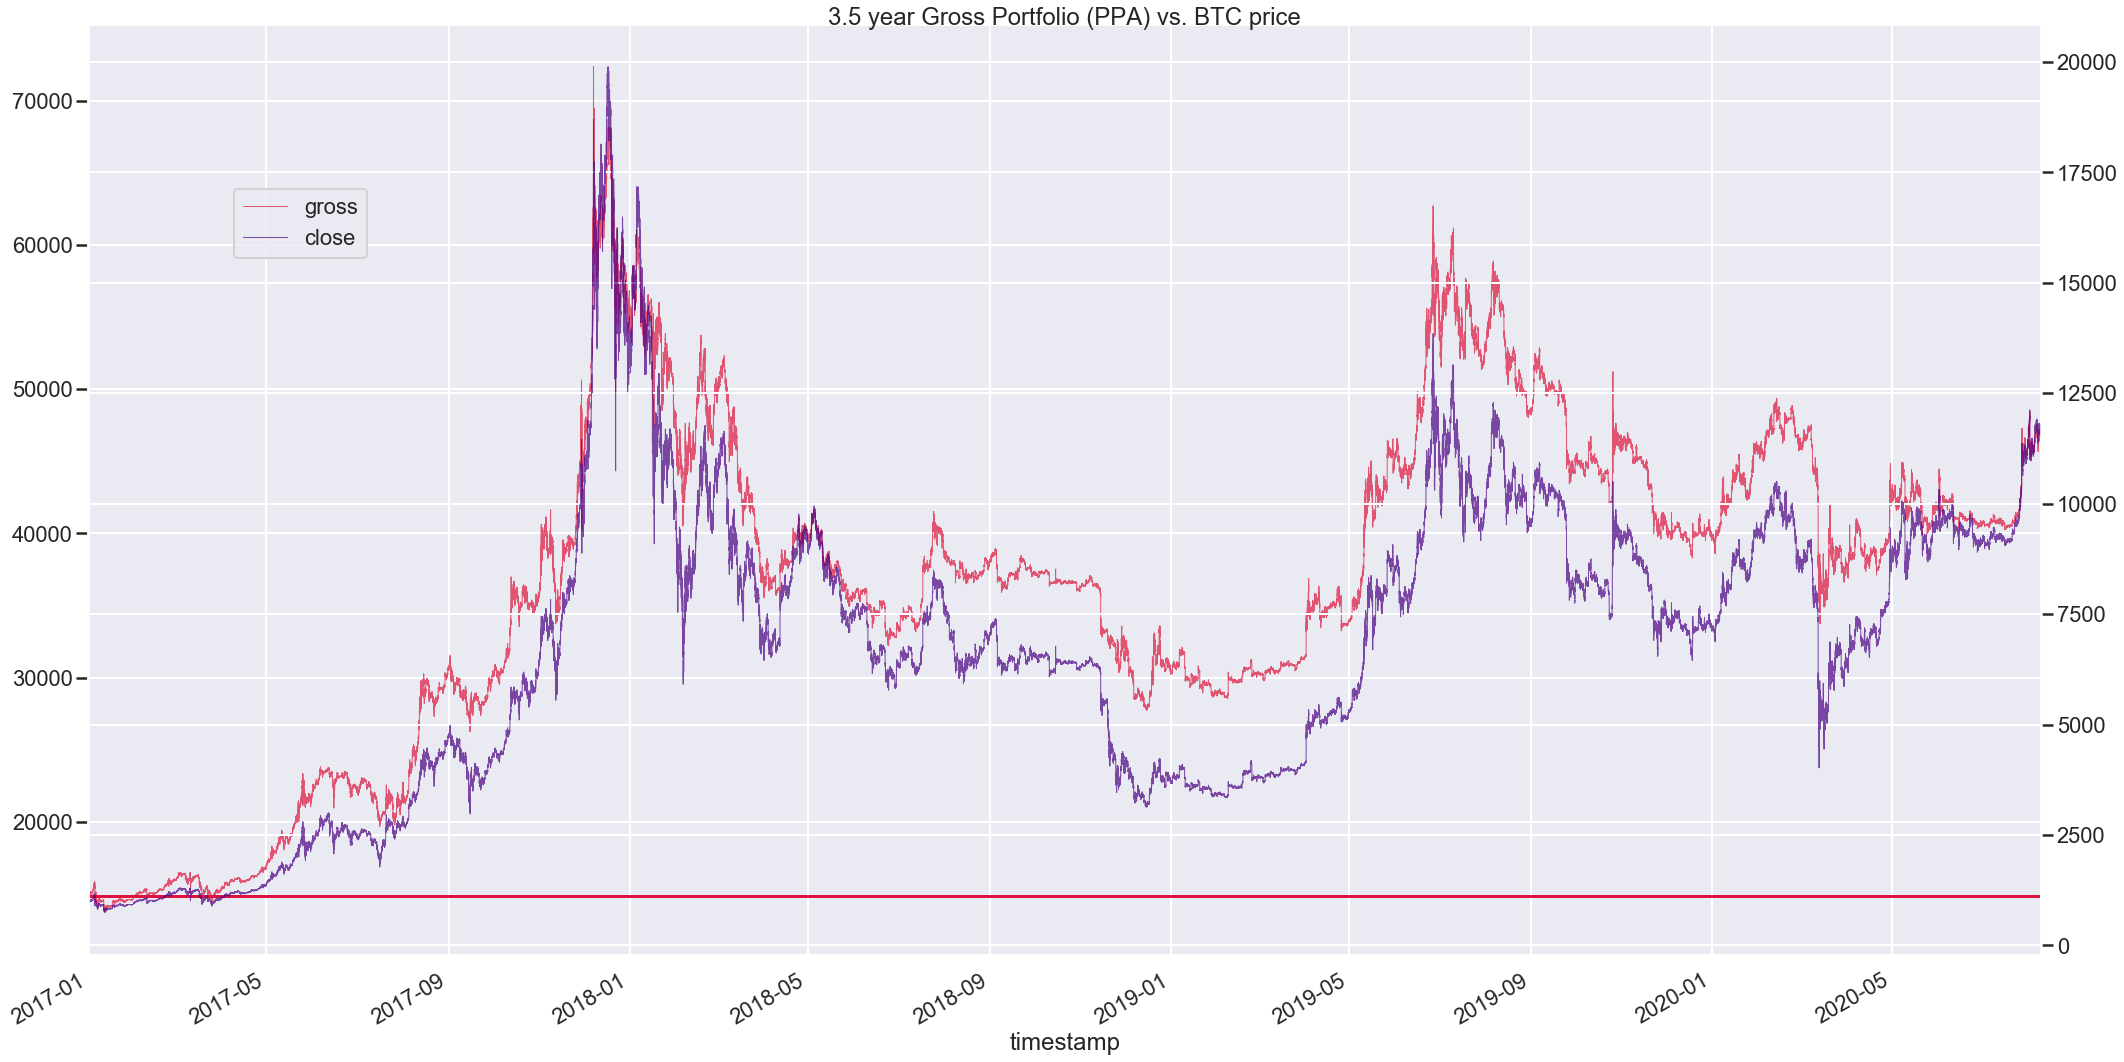

In [163]:
def draw_gross_portfolio(df): # dataframe. subset the timestamps to zoom in on an area

    sns.set(style="darkgrid", rc={'figure.figsize':(35,19)})
    sns.set_context('poster')
    
    w = 1 # line width
    # tinkering with alpha levels to make it more readable
    ax = df.plot(x="timestamp", y='gross', color='crimson', alpha=0.7, legend=False,linewidth=w)

#     ax2 = ax.twinx() # twin axes for multilines
#     df.plot(x="timestamp", y='adj_coin', ax=ax2, color='darkorange', alpha=0.7, legend=False,linewidth=w)

    ax3 = ax.twinx()
    df.plot(x='timestamp', y='close', ax=ax3, color='indigo', alpha=0.7, legend=False,linewidth=w, 
#             tick_params={
#     axis:'y',          # changes apply to the x-axis
#     which:'both',      # both major and minor ticks are affected
#     bottom:False,      # ticks along the bottom edge are off
#     top:False,         # ticks along the top edge are off
#     labelbottom:False}
           )

    ax.figure.legend(loc='lower right', bbox_to_anchor=(0.15, 0.58, 0,0))
    plt.title('3.5 year Gross Portfolio (PPA) vs. BTC price',
              fontdict={'verticalalignment': 'center',})
    # horizontal lines denote starting investment
    ax.axhline(y=df.iloc[0]['gross'], color='crimson')
#     ax2.axhline(y=df.iloc[0]['adj_coin'], color='darkorange')

    plt.show()
    return

last = sub[-1000:]
draw_gross_portfolio(sub)

In [38]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
sns.set(style="darkgrid", rc={'figure.figsize':(35,19)})
sns.set_context('poster')
# mel = pd.melt(df, id_vars=['timestamp'], value_vars=['cash','coin'])
# mel.head()
# this graph is taking SO_LONG to run holy moly
sns.lineplot(data=df, x='timestamp', y='close',)
plt.show()

In [ ]:
sns.set(style="darkgrid", rc={'figure.figsize':(35,19)})
sns.set_context('poster')
sns.lineplot(data=sub, x='timestamp', y='cash')
plt.show()

In [56]:
df['cash'].describe()

count     4.901300e+04
mean               inf
std                NaN
min     -7.643586e+305
25%       3.000000e+03
50%       3.000000e+03
75%       3.000000e+03
max                inf
Name: cash, dtype: float64

In [61]:
df.head()

,asset_class,asset_name,timestamp,low,high,open,close,5min_long_alert,5min_long_10pct_conf,5min_long_25pct_conf,...,60min_long_25pct_conf,60min_long_50pct_conf,60min_long_75pct_conf,60min_short_alert,60min_short_10pct_conf,60min_short_25pct_conf,60min_short_50pct_conf,60min_short_75pct_conf,cash,coin
0,crypto,btc,2017-01-01 0:00,973.35,973.40,973.37,973.39,0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3000.0,1.0
1,crypto,btc,2017-01-01 0:05,970.95,973.39,973.35,972.62,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,1.0
2,crypto,btc,2017-01-01 0:10,970.42,971.94,971.94,970.42,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,1.0
3,crypto,btc,2017-01-01 0:15,969.90,971.18,970.42,969.90,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,1.0
4,crypto,btc,2017-01-01 0:20,969.94,970.77,970.09,970.77,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,1.0


In [69]:
mony = list(df['cash'])
mony = mony[:40000]
max(mony)

3000.0

In [ ]:
# # Load an example dataset with long-form data
# # fmri = sns.load_dataset("fmri")

# # Plot the responses for different events and regions
# sns.lineplot(x="timepoint", y="signal",
#              hue="region", style="event",
#              data=mel)

In [24]:
p = portfolio(1000, df.iloc[0]['close'])
p.price

973.39